In [25]:
import cv2
import numpy as np
import tensorflow as tf
from model import Model
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
import random
#from google.colab.patches import cv2_imshow

import os 
import json 

In [26]:
def draw_labels(labels,img,show = False):
    
    labels = np.array(labels).astype(int) 
    img = np.array(img).astype(np.uint8)  
    h,w,c  = img.shape
    for bb in labels:
        if max(bb)<=1 and bb.shape[1]!=44:
            y = (bb[[1,3,5,7]]*h).astype(int)
            x = (bb[[0,2,4,6]]*w).astype(int)
            cv2.rectangle(img,(x[0],y[0]),(x[1],y[2]),(0,255,0),2)
        #if bb.shape[0] == 4:
        #    bb_int = bb.astype(int)
        #    cv2.rectangle(img,(bb_int[0],bb_int[1]),(bb_int[2],bb_int[3]),(0,255,0),2)
        else:
            y = (bb[[1,3]]).astype(int)
            x = (bb[[0,2]]).astype(int)
            cv2.rectangle(img,(x[0],y[0]),(x[1],y[1]),(0,255,0),2)
        
    if show:
        plt.figure(figsize = (15,30))
        plt.imshow(img)
    
    return img


def read_json(path):
    f = open(path)
    data = json.load(f)
    f.close()
    return data


def parse_labelme(data,img):
    h,w,c = img.shape
    points = []
    
    def clip(value,top):
        return min(max(value,0),top)
    
    for shapes in data["shapes"]:
        x0,y0 = np.array(shapes["points"])[0]
        x1,y1 = np.array(shapes["points"])[1]

        if x0>x1:
            x1,x0 = x0,x1 

        if y0>y1:
            y1,y0 = y0,y1 
            
        if x1 == x0 or y1 == y0:
            continue

        x1,x0,y1,y0 = clip(x1,w), clip(x0,w), clip(y1,h), clip(y0,h)
        points.append([int(x0), int(y0), int(x1), int(y1)])
    
    return np.array(points)

def labelme_to_tf(data,img):
    h,w,c = img.shape
    points = []
    
    def clip(value):
        return min(max(value,0),1)
    
    for shapes in data["shapes"]:
        x0,y0 = np.array(shapes["points"])[0]
        x1,y1 = np.array(shapes["points"])[1]
        
        if x0>x1:
            x1,x0 = x0,x1 
        
        if y0>y1:
            y1,y0 = y0,y1 
        
        x1,x0,y1,y0 = clip(x1),clip(x0),clip(y1),clip(y0)
        
        if x1 == x0 or y1 == y0:
            continue
        
        points.append([x0/w, y0/h,  x1/w, y0/h, x1/w, y1/h, x0/w, y1/h])
        
    return np.array(points)
    
    
def proportion_to_pixel(img,labels):
    h,w,c  = img.shape
    bb = []
    for proportional_bb in labels:
        #pix_bb = proportional_bb.copy()
        
        y = (proportional_bb[[1,3,5,7]]*h).astype(int)
        x = (proportional_bb[[0,2,4,6]]*w).astype(int)
        x_min, y_min, x_max, y_max = x[0],y[0],x[1],y[2]
        
        bb+=[[x_min, y_min, x_max, y_max]]
        
    return np.array(bb)
        
def pixel_to_proportion(img,labels):
    h,w,c  = img.shape
    bb = []
    for proportional_bb in labels:
        
        #pix_bb = proportional_bb.copy()
        #print("H",h,"W",w,"proportional_bb",proportional_bb)
        
        y = proportional_bb.astype(np.float32)[[0,2]]/h
        
        x = proportional_bb.astype(np.float32)[[0,2]]/w
        

        
        #print(x,y)
        
        x_min, y_min, x_max, y_max = x[0],y[0],x[1],y[1]
        
        if x_min == x_max or y_max == y_min:
            continue
        
        bb+=[[x_min, y_min, x_max, y_max]]
        
    return np.array(bb)
    




In [27]:
import albumentations as A

class Crop:
    def __init__(self,crop_proportions = None):
        self.iters = 0
        
        if crop_proportions is None:
            self.crop_proportions     = [0.6]
            
    def apply(self,img,bboxes,previous_transforms):
        h,w,c  = img.shape
        self.crops = {}
        
        for proportion in self.crop_proportions :

            visibility = 1 if proportion < 0.22 else 0.94 

            self.crops[str(round(proportion,3))] = A.Compose([
                A.RandomCrop(width=int(h*proportion), height=int(h*proportion))
            ],bbox_params = A.BboxParams(format='pascal_voc', min_visibility=0.5, label_fields=[]))

        
        
        transformations = {}
        
        for proportion,crop in self.crops.items():

            croped = crop(image=img, bboxes=bboxes)
            
            
            tries = 0
            while len(croped["bboxes"])<3 and tries <= 200:
                croped = crop(image=img, bboxes=bboxes)
                tries+=1
                #print(len(croped["bboxes"]),"tries ",tries)
            
            if tries==201:
                print("crop tries exceed 200")
                continue
            #print(len(croped["bboxes"]))
                
            transformations[previous_transforms+"+crop:v"+str(self.iters)+"-p"+str(proportion)] = {"image":croped["image"],"bboxes":croped["bboxes"]}
                
            self.iters+=1
            
        return transformations
            

In [28]:
def padding_img(img):
    h,w,c = img.shape
    h0 = int((h-w)/2)
    hf = int(h0+w)
    delta = abs(h-w)
    if h>w:
        w = h
    else:
        h = w    
    mock = np.zeros((h,w,c))
    mock[int(delta/2):int(w-delta/2),:,:] = img

    detection_frame        = cv2.resize(mock, (320,320), interpolation = cv2.INTER_AREA)
    detection_frame        = np.expand_dims(detection_frame,axis=0).astype(np.uint8)
    return detection_frame

def reshape(img):
    detection_frame        = cv2.resize(img, (320,320), interpolation = cv2.INTER_AREA)
    detection_frame        = np.expand_dims(detection_frame,axis=0).astype(np.uint8)
    return detection_frame


In [29]:
def draw_detection(boxes, classes, scores,mock,threshold=0.5,color = 'r'):
    h,w,c = mock.shape
    
    color = (255,0,0) if color == 'r' else (0,0,255)
    size  =  2 if color == 'r' else 10
    
    for bb,c,s in zip(boxes, classes, scores):
        if s>threshold:

            '''
            x0,y0 ------
            |          |
            |          |
            |          |
            --------x1,y1
            '''
            
            y0 = int(bb[0]*h)
            x0 = int(bb[1]*w)
            y1 = int(bb[2]*h)           
            x1 = int(bb[3]*w)  
            

            xc = abs(int(x0 + abs(x1-x0)/2)) 
            yc = abs(int(y0 + abs(y1-y0)/2))
            r  = max(int(abs(y1-y0)/2),int(abs(x1-x0)/2)) 
            Xc = xc
            Yc = yc
            
            
            mock = cv2.circle(mock, (xc,yc), r , color, 3)
    return mock

def get_label_boxes(img,bboxes):

    boxes = []
    h,w,c = img.shape
    for bb in bboxes:
        x0 = float(bb[0]/h)
        y0 = float(bb[1]/w)
        x1 = float(bb[2]/h)           
        y1 = float(bb[3]/w)
        boxes.append((y0,x0,y1,x1))

    bboxes    = np.array(boxes)
    scores    = np.array([1]*bboxes.shape[0])
    
    return bboxes,scores


def get_centers(boxes):
    centers = []
    for bb in boxes:

        x0 = float(bb[0])
        y0 = float(bb[1])
        x1 = float(bb[2])           
        y1 = float(bb[3])
        
        xc = round(abs((x0 + abs(x1-x0)/2)),4) 
        yc = round(abs((y0 + abs(y1-y0)/2)),4)

        centers.append((xc,yc))

    return np.array(centers)

In [30]:
def bb_intersection_over_union(boxA, boxB):
    
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [31]:
def get_IoUs(detection_boxes,scores,label_bboxes,threshold = 0.5):

    center_det    = get_centers(detection_boxes[scores>threshold])
    center_labels = get_centers(label_bboxes)
    distances     = np.zeros((center_labels.shape[0],center_det.shape[0]))

    for i, det_c in enumerate(center_det):
        for j,label_c in enumerate(center_labels):
            distances[j,i] = round((((label_c[0]-det_c[0])**2+(label_c[1]-det_c[1])**2)**0.5),3)

    matches = np.argwhere(distances<0.02)

    IoUs = []
    for m in matches:
        label_index,d_index = m
        IoU = bb_intersection_over_union(detection_boxes[d_index],label_bboxes[label_index])
        IoUs.append(IoU)
    
    mean_IoU = sum(IoUs)/len(IoUs) if len(IoUs)> 0 else 0
    detection_accuracy = max(1 - abs(len(detection_boxes[scores>threshold])-len(label_bboxes))/len(label_bboxes),0)
    
    return mean_IoU,detection_accuracy

  0%|                                                   | 0/348 [00:07<?, ?it/s]

[0.95720229 0.95720229 0.95720229 0.95720229 0.95720229 0.95720229
 0.95720229 0.95720229 0.95720229 0.95720229 0.95720229 0.95720229
 0.95720229 0.95600531 0.95569699 0.95655751 0.95414722 0.95414722
 0.95369413 0.95285729 0.95160313 0.9505577  0.9505577  0.95115082
 0.9539686  0.9539686  0.9539686  0.9539686  0.9539686  0.94463912
 0.94463912 0.93128453 0.93128453 0.93128453 0.93128453 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]



/tmp/ipykernel_13583/3564088855.py:119: RuntimeWarning: Mean of empty slice.
  plt.plot(tresholds,np.array(all_ious).mean(axis = 0),c= 'r')
/home/pixlog/install/enviroments/train/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

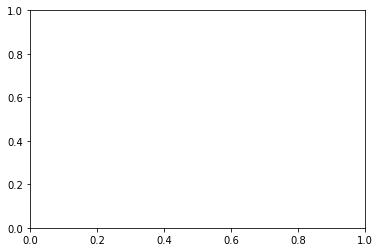

In [103]:
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
import random
import os 
import json 

from model import Model

def reshape(img):
    detection_frame        = cv2.resize(img, (320,320), interpolation = cv2.INTER_AREA)
    detection_frame        = np.expand_dims(detection_frame,axis=0).astype(np.uint8)
    return detection_frame

def bb_intersection_over_union(boxA, boxB):
    
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

def get_IoUs(detection_boxes,scores,label_bboxes,threshold = 0.5):

    center_det    = get_centers(detection_boxes[scores>threshold])
    center_labels = get_centers(label_bboxes)
    distances     = np.zeros((center_labels.shape[0],center_det.shape[0]))

    for i, det_c in enumerate(center_det):
        for j,label_c in enumerate(center_labels):
            distances[j,i] = round((((label_c[0]-det_c[0])**2+(label_c[1]-det_c[1])**2)**0.5),3)

    matches = np.argwhere(distances<0.02)

    IoUs = []
    for m in matches:
        label_index,d_index = m
        IoU = bb_intersection_over_union(detection_boxes[d_index],label_bboxes[label_index])
        IoUs.append(IoU)
    
    mean_IoU = sum(IoUs)/len(IoUs) if len(IoUs)> 0 else 0
    detection_accuracy = max(1 - abs(len(detection_boxes[scores>threshold])-len(label_bboxes))/len(label_bboxes),0)
    
    return mean_IoU,detection_accuracy

def get_labels(df,path):
    labels = df[df.iloc[:,1] == path].iloc[:,3:]
    y      = (np.array(labels)[:,[1,3,5,7]])
    x      = (np.array(labels)[:,[0,2,4,6]])
    x_min  = x[:,0].reshape(-1,1) 
    y_min  = y[:,0].reshape(-1,1)
    x_max  = x[:,1].reshape(-1,1)
    y_max  = y[:,2].reshape(-1,1)
    bboxes = np.concatenate([x_min, y_min, x_max, y_max],axis = 1)
    scores = np.array([1]*len(arr))
    return bboxes,scores

def get_metrics(detection_frame,model):
    
    detection_boxes, classes, scores = model.predict(detection_frame)

    IoUs = []
    dets = []
    tresholds = []
    for t in np.linspace(0,1,50):
        IoU,det = get_IoUs(detection_boxes,scores,label_bboxes,threshold = t)
        IoUs.append(IoU)
        dets.append(det)
        tresholds.append(t)
        #metrics.append((t,IoU,det))

    return np.array(IoUs), np.array(dets), np.array(tresholds)


model         = Model("models/weights/0.0.1.tflite")
df            = pd.read_csv("whole.csv")
validation_df = df[df.iloc[:,0] == "VALIDATION"]
paths         = validation_df.iloc[:,1].unique().tolist()
all_ious      = []
all_dets      = []

for path in tqdm(paths):

    image_path = path
    root       = label_paths.replace(".json","").replace("/","_")
    
    img              = cv2.imread(image_path)[:,:,::-1]
    bboxes,scores    = get_labels(df,path)
    detection_frame  = reshape(img)
    
    label_bboxes,label_scores = get_labels(df,path)
    IoUs,dets,tresholds       = get_metrics(detection_frame,model)
    
    all_ious.append(IoUs)
    all_dets.append(dets)
   
    
plt.plot(tresholds,np.array(all_ious).mean(axis = 0),c= 'r')
plt.plot(tresholds,np.array(all_dets).mean(axis = 0),c= 'black')

    

In [50]:
for label_paths in paths:
    image_path  = label_paths
    label_paths = image_path.replace(".jpg",".json")
    root   = label_paths.replace(".json","").replace("/","_")

    img    = cv2.imread(image_path)[:,:,::-1]

    data   = read_json(label_paths)
    labels = parse_labelme(data,img)
    tests  = crop.apply(img,labels,'_')

FileNotFoundError: [Errno 2] No such file or directory: 'augumentations/CENIBRA/CENIBRA_IMG_6327_RAW.json'

In [93]:
model            = Model("models/weights/0.0.1.tflite")
crop             = Crop()
img              = cv2.imread("CENIBRA/IMG_6272.jpg")[:,:,::-1]
data             = read_json("CENIBRA/IMG_6272.json")
labels           = parse_labelme(data,img)
tests            = crop.apply(img,labels,'_')
raw              = tests['_+crop:v0-p0.6']["image"] 
detection_frame  = reshape(raw)

label_bboxes,label_scores    = get_label_boxes(tests["_+crop:v0-p0.6"]["image"], tests["_+crop:v0-p0.6"]["bboxes"])

print(label_bboxes,label_scores)


detection_boxes, classes, scores = model.predict(detection_frame)
detection_frame[0]     = draw_detection(detection_boxes, classes, scores,detection_frame[0],threshold = 0.5)
get_IoUs(detection_boxes,scores,label_bboxes,threshold = 0.47)


[[0.         0.07883131 0.0738699  0.14112459]
 [0.04796031 0.09647189 0.1598677  0.21775083]
 [0.00937155 0.23869901 0.15380375 0.39029768]
 [0.36052922 0.         0.54024256 0.176957  ]
 [0.53969129 0.         0.72546858 0.12734289]
 [0.15325248 0.00716648 0.36824697 0.21499449]
 [0.15766262 0.25744212 0.27783903 0.37816979]
 [0.3384785  0.21113561 0.45314223 0.33020948]
 [0.44597574 0.19514884 0.56063947 0.30981257]
 [0.42006615 0.32249173 0.49614112 0.40352811]
 [0.53528115 0.30705623 0.60529217 0.38423374]
 [0.60859978 0.17585447 0.71830209 0.28445424]
 [0.63120176 0.26185226 0.707828   0.33572216]
 [0.74641676 0.1047409  0.88754135 0.25137817]
 [0.71830209 0.27067255 0.83241455 0.37816979]
 [0.86052922 0.03914002 0.97794928 0.15545755]
 [0.81808159 0.24310915 0.92888644 0.35777288]
 [0.0154355  0.48732084 0.18081588 0.63836825]
 [0.13891951 0.42227122 0.24255788 0.52480706]
 [0.23208379 0.31863286 0.4277839  0.51653804]
 [0.39746417 0.42668137 0.53472988 0.57828004]
 [0.47739802 

(0.986325699220585, 0.9111111111111111)

In [40]:
def get_metrics(image,path = "models/model-det-400.tflite"):
    
    model = Model(path)
    for key in image:
        
        raw                       = image[key]["image"]
        detection_frame           = reshape(raw)
        label_bboxes,label_scores = get_label_boxes(image[key]["image"], image[key]["bboxes"])
        
        
        detection_boxes, classes, scores = model.predict(detection_frame)
        
        IoUs = []
        dets = []
        tresholds = []
        for t in np.linspace(0,1,50):
            IoU,det = get_IoUs(detection_boxes,scores,label_bboxes,threshold = t)
            IoUs.append(IoU)
            dets.append(det)
            tresholds.append(t)
            #metrics.append((t,IoU,det))

    return np.array(IoUs), np.array(dets), np.array(tresholds)



In [41]:
import os 
from random import shuffle

def generate_all_label_paths():
    
    folders =   ['CENIBRA']

    label_paths = []

    for folder in folders:
        files = os.listdir(folder)
        for file in files:
            if ".json" in file:
                label_paths.append(folder+"/"+file)

    for label in label_paths:
        image_path = label.replace(".json",".jpg")
        
    return label_paths

In [42]:
img    = cv2.imread(image_path)
data   = read_json(label_paths)
labels = parse_labelme(data,img)
bboxes = pixel_to_proportion(img,labels)

In [47]:
from tqdm import tqdm

labels = generate_all_label_paths()

shuffle(labels)

all_ious = []
all_dets = []

for label_paths in tqdm(labels):
    try:
    
        image_path = label_paths.replace(".json",".jpg")
        root       = label_paths.replace(".json","").replace("/","_")

        img    = cv2.imread(image_path)[:,:,::-1]

        data   = read_json(label_paths)
        labels = parse_labelme(data,img)
        tests  = crop.apply(img,labels,'_')

        IoUs, dets, tresholds = get_metrics(tests,path ="models/weights/0.0.1.tflite") 

        all_ious.append(IoUs)
        all_dets.append(dets)
    
    except Exception as e:
        print(e)
 
    

 83%|███████████████████████████████████▋       | 63/76 [02:35<01:02,  4.84s/it]

crop tries exceed 200
local variable 'IoUs' referenced before assignment


100%|███████████████████████████████████████████| 76/76 [03:10<00:00,  2.51s/it]


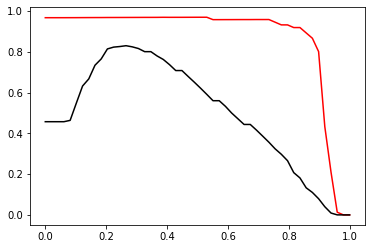

In [48]:
plt.plot(tresholds,np.array(all_ious).mean(axis = 0),c= 'r')
plt.plot(tresholds,np.array(all_dets).mean(axis = 0),c= 'black')

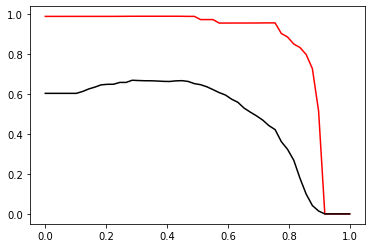

In [62]:
plt.plot(tresholds,np.array(all_ious).mean(axis = 0),c= 'r')
plt.plot(tresholds,np.array(all_dets).mean(axis = 0),c= 'black')

0.9842581248750322


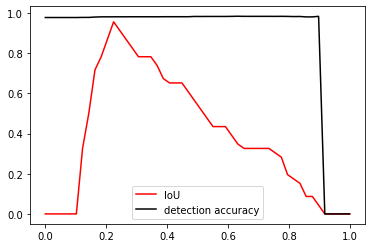

In [61]:
plt.plot(np.array(metrics)[:,0] , np.array(metrics)[:,2],c= 'r')
plt.plot(np.array(metrics)[:,0] , np.array(metrics)[:,1],c= 'black')
plt.legend(["IoU","detection accuracy"])
    
print(np.array(metrics)[:,1].max())

0.9897646667540105


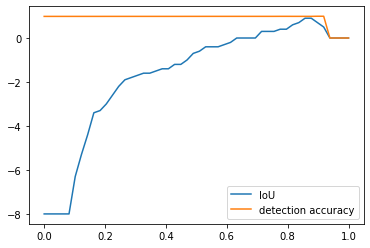

0.9928007965841033


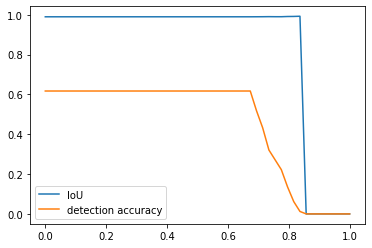

In [12]:
metrics = get_metrics(tests,path ="models/model-det-400.tflite") 
plt.plot(np.array(metrics)[:,0] , np.array(metrics)[:,1])
plt.plot(np.array(metrics)[:,0] , np.array(metrics)[:,2])
plt.legend(["IoU","detection accuracy"])
print(np.array(metrics)[:,1].max())

In [13]:
center_det    = get_centers(detection_boxes)
center_labels = get_centers(label_bboxes)
IoUs          = np.zeros((center_labels.shape[0],center_det.shape[0]))

for i, det_bb in enumerate(detection_boxes):
    for j,label_bb in enumerate(label_bboxes):
        IoUs[j,i] = bb_intersection_over_union(det_bb,label_bb)

matches = np.argwhere(IoUs>.95)


raw                    = tests['_+crop:v0-p0.6']["image"]
detection_frame        = reshape(raw)
detection_boxes, classes, scores = model.predict(detection_frame)
label_bboxes,scores    = get_label_boxes(tests["_+crop:v0-p0.6"]["image"], tests["_+crop:v0-p0.6"]["bboxes"])

img_drawn              = draw_detection(detection_boxes, classes, scores,detection_frame[0] ,threshold=0.5,color = 'blue')
img_drawn              = draw_detection(label_bboxes, classes, scores,img_drawn ,threshold=0.5)

plt.imshow(img_drawn)

KeyError: '_+crop:v0-p0.6'

In [162]:
label_bboxes,scores = get_label_boxes(tests["_+crop:v0-p0.3"]["image"], tests["_+crop:v0-p0.3"]["bboxes"])
   
boxes,conf = get_label_boxes(img,bboxes)
#get_centers(boxes)

boxes

KeyError: '_+crop:v0-p0.3'

In [423]:
detection_frame        = tests['_+crop:v0-p0.2']["image"]
detection_frame        = reshape(detection_frame)
boxes, classes, scores = model.predict(detection_frame)

img_drawn              = draw_labels(tests['_+crop:v0-p0.2']["bboxes"],detection_frame[0],True)

mock = draw_detection(boxes, classes, scores,detection_frame[0],threshold=0.5)
plt.imshow(detection_frame[0].astype(np.uint))

KeyError: '_+crop:v0-p0.2'